In [1]:
import torch
import numpy as np
from pathlib import Path
import logging
from torch.utils.data import DataLoader
from dataset import ViTacVisDataset
from torch.utils.tensorboard import SummaryWriter
import argparse
from torch import nn
import torch.nn.functional as F

In [2]:
# parser = argparse.ArgumentParser("Train model.")
# parser.add_argument("--epochs", type=int, help="Number of epochs.", required=True)
# parser.add_argument("--data_dir", type=str, help="Path to data.", required=True)
# parser.add_argument(
#     "--checkpoint_dir", type=str, help="Path for saving checkpoints.", required=True
# )

# parser.add_argument("--lr", type=float, help="Learning rate.", required=True)
# parser.add_argument(
#     "--sample_file", type=int, help="Sample number to train from.", required=True
# )
# parser.add_argument(
#     "--batch_size", type=int, help="Batch Size.", required=True
# )

In [3]:
class FLAGS():
    def __init__(self):
        self.data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN/'
        self.batch_size = 8
        self.sample_file = 1
        self.lr = 0.01
        self.epochs = 2000
        self.output_size = 20
args = FLAGS()

In [4]:
device = torch.device("cuda:2")

In [5]:
train_dataset = ViTacVisDataset(
    path=args.data_dir, sample_file=f"train_80_20_{args.sample_file}.txt", output_size=args.output_size
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)
test_dataset = ViTacVisDataset(
    path=args.data_dir, sample_file=f"test_80_20_{args.sample_file}.txt", output_size=args.output_size
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4
)

In [6]:
class CNN3D(nn.Module):

    def __init__(self):
        
        super(CNN3D, self).__init__()
        self.input_size = 8*5*3
        self.hidden_dim = 32
        self.num_layers = 1
        
        self.conv1 = nn.Conv3d(in_channels=2, out_channels=2, kernel_size=(10,5,5), stride=(5,2,2))
        self.conv2 = nn.Conv3d(in_channels=2, out_channels=4, kernel_size=(5,3,3), stride=(3,2,2))
        self.conv3 = nn.Conv3d(in_channels=4, out_channels=8, kernel_size=(5,3,3), stride=(3,2,2))

        # Define the output layer
        self.fc = nn.Linear(np.prod([8, 6, 6, 5]), 20)
        
        self.drop = nn.Dropout(0.5)
        
        #self.fc_mlp = nn.Linear(6300, self.input_size)

    def forward(self, x):
        
        #print('Model input ', x.size())
        batch_size, C, H, W, sequence_size = x.size()
        x = x.view([batch_size, C, sequence_size, H, W])
        #print('Model input ', x.size())
        
        # pass to cnn3d
        out = self.conv1(x)
        out = F.relu(out)
        #print('conv1 out: ', out.shape)
        out = self.conv2(out)
        out = F.relu(out)
        #print('conv2 out: ', out.shape)
        out = self.conv3(out)
        out = F.relu(out)
        #print('conv3 out: ', out.shape)
        out = out.view([batch_size, np.prod([8, 6, 6, 5])])
        out = self.fc(out)
        
        out = self.drop(out)
        return out

In [7]:
net = CNN3D().to(device)
# Create snn loss instance.
criterion = nn.CrossEntropyLoss()
# Define optimizer module.
optimizer = torch.optim.RMSprop(
    net.parameters(), lr=0.00001)

In [8]:
train_accs = []
test_accs = []
train_loss = []
test_loss = []
for epoch in range(args.epochs):
    # Training loop.
    net.train()
    correct = 0
    batch_loss = 0
    train_acc = 0
    for i, (in_viz, _, label) in enumerate(train_loader, 0):

        in_viz = in_viz.to(device)
        label = label.to(device)
        # Forward pass of the network.
        #print(in_viz.shape)
        out = net.forward(in_viz)
        #print(out_tact.shape)
        # Calculate loss.
        #print(label.shape)
        loss = criterion(out, label)
        #print(loss)

        batch_loss += loss.cpu().data.item()
        # Reset gradients to zero.
        optimizer.zero_grad()
        # Backward pass of the network.
        loss.backward()
        # Update weights.
        optimizer.step()

        _, predicted = torch.max(out.data, 1)
        correct += (predicted == label).sum().item()

    # Reset training stats.
    train_acc = correct/len(train_loader.dataset)
    train_loss.append(batch_loss/len(train_loader.dataset))
    train_accs.append(train_acc)
    #print(train_acc, batch_loss)

    # testing
    net.eval()
    correct = 0
    batch_loss = 0
    test_acc = 0
    with torch.no_grad():
        for i, (in_viz, _, label) in enumerate(test_loader, 0):
            in_viz = in_viz.to(device)
            # Forward pass of the network.
            out = net.forward(in_viz)
            label = label.to(device)
            _, predicted = torch.max(out.data, 1)
            correct += (predicted == label).sum().item()
            # Calculate loss.
            loss = criterion(out, label)
            batch_loss += loss.cpu().data.item()

    test_loss.append(batch_loss/len(test_loader.dataset))
    test_acc = correct/len(test_loader.dataset)
    test_accs.append(test_acc)
    if epoch%10 == 0:
        print(epoch, 'Train:', train_acc, 'Test:', test_acc)

0 Train: 0.05416666666666667 Test: 0.08333333333333333
10 Train: 0.14166666666666666 Test: 0.15
20 Train: 0.1875 Test: 0.2
30 Train: 0.25833333333333336 Test: 0.26666666666666666
40 Train: 0.3458333333333333 Test: 0.3
50 Train: 0.38333333333333336 Test: 0.31666666666666665
60 Train: 0.4666666666666667 Test: 0.3333333333333333
70 Train: 0.44166666666666665 Test: 0.3
80 Train: 0.4708333333333333 Test: 0.3333333333333333
90 Train: 0.475 Test: 0.36666666666666664
100 Train: 0.49166666666666664 Test: 0.35
110 Train: 0.44583333333333336 Test: 0.4
120 Train: 0.5083333333333333 Test: 0.4166666666666667
130 Train: 0.4375 Test: 0.43333333333333335
140 Train: 0.5125 Test: 0.4666666666666667
150 Train: 0.5125 Test: 0.48333333333333334
160 Train: 0.5166666666666667 Test: 0.5
170 Train: 0.4666666666666667 Test: 0.55
180 Train: 0.49583333333333335 Test: 0.5333333333333333
190 Train: 0.48333333333333334 Test: 0.5166666666666667
200 Train: 0.5083333333333333 Test: 0.55
210 Train: 0.5083333333333333 Tes

KeyboardInterrupt: 

In [9]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [10]:
params

31634

In [11]:
import matplotlib.pyplot as plt

In [12]:
np.max(test_accs)

0.8

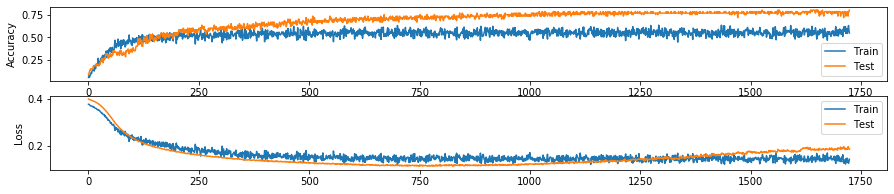

In [13]:
fig, ax = plt.subplots(2, figsize=(15,3))
ax[0].plot(train_accs)
ax[0].plot(test_accs)
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_loss) 
ax[1].plot(test_loss)
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Test'])

plt.show()